In [152]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import backtesting
backtesting.set_bokeh_output(notebook=False)
import warnings
warnings.filterwarnings("ignore")
warnings.warn('Jupyter Notebook detected.')
import yfinance as yf
import datetime as dt
import talib
import pandas as pd
import matplotlib.pyplot as plt


In [60]:
btc_data = yf.Ticker('BTC-USD')
btc = btc_data.history(start=dt.datetime(2020,1,1), end =dt.datetime(2025,8,14),interval= "1d" ).iloc[:, :4]#*10**-6
btc

,Open,High,Low,Close
Date,,,,
2020-01-01 00:00:00+00:00,7194.892090,7254.330566,7174.944336,7200.174316
2020-01-02 00:00:00+00:00,7202.551270,7212.155273,6935.270020,6985.470215
2020-01-03 00:00:00+00:00,6984.428711,7413.715332,6914.996094,7344.884277
2020-01-04 00:00:00+00:00,7345.375488,7427.385742,7309.514160,7410.656738
2020-01-05 00:00:00+00:00,7410.451660,7544.497070,7400.535645,7411.317383
...,...,...,...,...
2025-08-09 00:00:00+00:00,116678.273438,117906.609375,116363.835938,116500.359375
2025-08-10 00:00:00+00:00,116497.718750,119320.710938,116485.164062,119306.757812
2025-08-11 00:00:00+00:00,119306.812500,122321.093750,118159.031250,118731.445312


In [61]:
class Rsi0scillator(Strategy):
    lower_band = 30
    upper_band = 70
    rsi_window = 14
    def init(self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)
        
    def next(self):
        if crossover(self.rsi, self.upper_band):
            self.position.close()
        elif crossover(self.rsi, self.lower_band):
            self.buy()
bt = Backtest(spy, Rsi0scillator, cash=10, commission=.02)
stat = bt.run()
bt.plot()
print(stat)


NameError: name 'spy' is not defined

In [62]:
type(btc)

pandas.core.frame.DataFrame

In [63]:
class BTSMA(Strategy):
    
    n1 = 20
    n2 = 50
    opt_ranges = {
        'n1': range(5, 30, 10),
        'n2': range(10, 30, 10),
    }


    def init(self):
        self.sma1 = self.I(talib.SMA, self.data.Close, self.n1)
        self.sma2 = self.I(talib.SMA, self.data.Close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In [ ]:
btc.iloc[[1]]

,Open,High,Low,Close
Date,,,,
2020-01-02 00:00:00+00:00,7202.55127,7212.155273,6935.27002,6985.470215


In [ ]:
pd.concat([btc,btc.iloc[1]])

TypeError: 'Series' object is not callable

In [64]:
def optimize_auto(bt: Backtest, StrategyCls, maximize='Sharpe Ratio'):
    ranges = getattr(StrategyCls, 'opt_ranges', None)
    if not ranges:
        raise ValueError("Define 'opt_ranges' en tu Strategy (dict de iterables).")
    # Ejemplo de restricción típica para MAs: n1 < n2
    constraint = lambda p: getattr(p, 'n1', 1) < getattr(p, 'n2', 2)
    return bt.optimize(**ranges, maximize=maximize, constraint=constraint)

In [65]:
bt = Backtest(btc*10**-6, BTSMA, cash=1000, commission=.0025)
stats =optimize_auto(bt,BTSMA,maximize='Equity Final [$]')
# stats = bt.run()  # o bt.optimize(...)
print(stats)
"""print(stats._strategy.params)   # {'n1': 20, 'n2': 50}
print(getattr(stats._strategy, stats._strategy.params[1]))    # 20
print(stats._strategy.n1) """       # 50

Start                     2020-01-01 00:00...
End                       2025-08-13 00:00...
Duration                   2051 days 00:00:00
Exposure Time [%]                    97.41715
Equity Final [$]                   1744.72163
Equity Peak [$]                     5119.7021
Commissions [$]                    1134.44634
Return [%]                           74.47216
Buy & Hold Return [%]              1324.68416
Return (Ann.) [%]                    10.40712
Volatility (Ann.) [%]                68.04565
CAGR [%]                             10.41245
Sharpe Ratio                          0.15294
Sortino Ratio                         0.27233
Calmar Ratio                          0.13515
Alpha [%]                            31.92339
Beta                                  0.03212
Max. Drawdown [%]                   -77.00408
Avg. Drawdown [%]                   -10.32029
Max. Drawdown Duration     1678 days 00:00:00
Avg. Drawdown Duration      110 days 00:00:00
# Trades                          

"print(stats._strategy.params)   # {'n1': 20, 'n2': 50}\nprint(getattr(stats._strategy, stats._strategy.params[1]))    # 20\nprint(stats._strategy.n1) "

In [ ]:
stats = bt.optimize(
    n1=[20],      # aunque sea un solo valor
    n2=[50],
    maximize='Sharpe Ratio'
)
print(stats._strategy._params)  # {'n1': 20, 'n2': 50}

{'n1': np.int64(20), 'n2': np.int64(50)}


In [ ]:
def walk_forward(data,strategy):
    
    train = data.iloc[:len(data)//2]
    test =  data.iloc[len(data)//2:int((len(data)//1.5))]
    
    stats_master =[]
    bt = Backtest(train, strategy, cash=10, commission=.0025)
    stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
    stats_master.append(stats)
    for i in range(len(data)//2,len(data)) :
        
        test=pd.concat([test,data.iloc[[i]]])
        bt = Backtest(test, strategy, cash=10, commission=.0025)
        
        stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
        stats_master.append(stats)
    return stats_master

In [226]:
def walk_forward_o(data,strategy,depp=2):
    
    train = data.iloc[:len(data)//2]
    test =  data.iloc[len(data)//2:int((len(data)//1.5))]
    
    stats_master =[]
    bt = Backtest(train, strategy, cash=10, commission=.0025)
    stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
    stats_master.append(stats)
    for i in range(len(data)//2,len(data),depp) :
        train = pd.concat([train[i:],test]) 
        test=pd.concat([test[i:],data.iloc[i-depp:i]])
        bt = Backtest(test, strategy, cash=10, commission=.0025)
        
        stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
        stats_master.append(stats)
    return stats_master
    
p =walk_forward_o(btc*10**-6,BTSMA)


In [ ]:
def walk_forward_o(data,strategy,depp=2):
    
    train = data.iloc[:len(data)//2]
    test =  data.iloc[len(data)//2:int((len(data)//1.5))]
    
    stats_master =[]
    bt = Backtest(train, strategy, cash=10, commission=.0025)
    stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
    stats_master.append(stats)
    bt = Backtest(test, strategy, cash=10, commission=.0025)
    stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
    stats_master.append(stats)
    for i in range(len(data)//2,len(data),depp) :
        train = pd.concat([train[i:],test]) 
        test=pd.concat([test[i:],data.iloc[i-depp:i]])
        bt = Backtest(train, strategy, cash=10, commission=.0025)
        stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
        stats_master.append(stats)
        bt = Backtest(test, strategy, cash=10, commission=.0025)
        stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
        stats_master.append(stats)
    return stats_master
    
p =walk_forward_o(btc*10**-6,BTSMA)


In [227]:
p

[Start                     2020-01-01 00:00...
 End                       2022-10-22 00:00...
 Duration                   1025 days 00:00:00
 Exposure Time [%]                    94.05458
 Equity Final [$]                      22.2539
 Equity Peak [$]                      51.17017
 Commissions [$]                       6.31293
 Return [%]                          122.53898
 Buy & Hold Return [%]               121.86397
 Return (Ann.) [%]                    32.91986
 Volatility (Ann.) [%]                95.36088
 CAGR [%]                             32.95677
 Sharpe Ratio                          0.34521
 Sortino Ratio                         0.78359
 Calmar Ratio                          0.54148
 Alpha [%]                           123.32433
 Beta                                 -0.00644
 Max. Drawdown [%]                   -60.79554
 Avg. Drawdown [%]                     -9.4179
 Max. Drawdown Duration      652 days 00:00:00
 Avg. Drawdown Duration       53 days 00:00:00
 # Trades    

In [ ]:
def walk_forward(data,strategy,depp=100):
    
    train = data.iloc[:len(data)//2]
    test =  data.iloc[len(data)//2:int((len(data)//1.5))]
    
    stats_master =[]
    bt = Backtest(train, strategy, cash=10, commission=.0025)
    stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
    stats_master.append(stats)
    for i in range(len(data)//2,len(data),depp) :
        
        test=pd.concat([test,data.iloc[i-depp:i]])
        bt = Backtest(test, strategy, cash=10, commission=.0025)
        
        stats=optimize_auto(bt,strategy,maximize='Equity Final [$]')
        stats_master.append(stats)
    return stats_master
    
p =walk_forward(btc*10**-6,BTSMA)


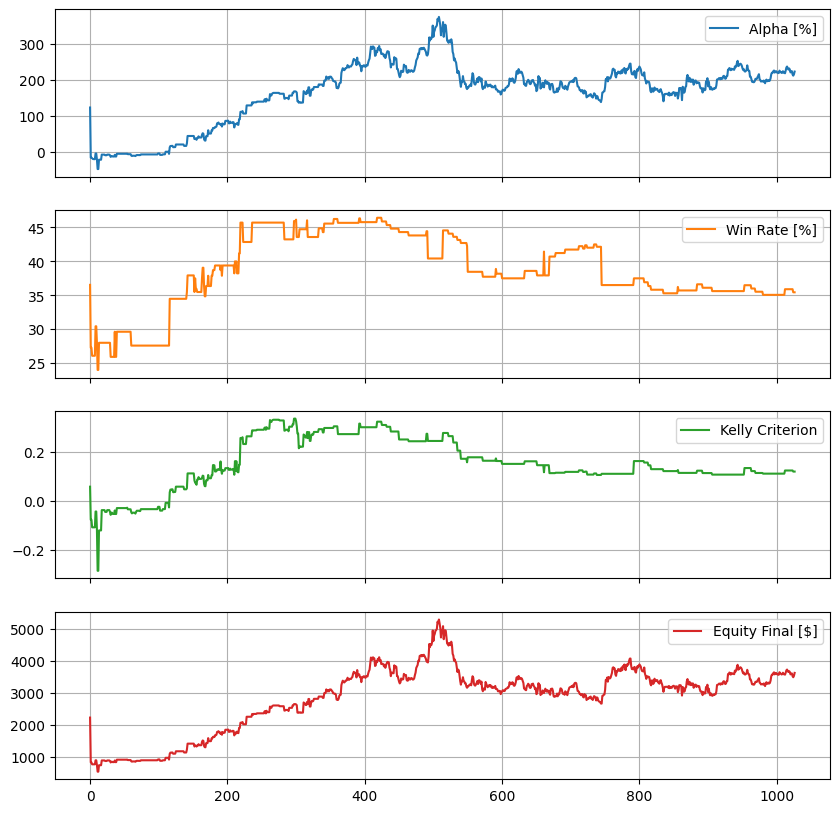

In [215]:
def plot_stats(stats,paranm_to_plot=['Alpha [%]','Win Rate [%]','Kelly Criterion','Equity Final [$]']):
    #fig, ax = plt.subplots(figsize=(5, 3), layout='constrained')
    stats_df= pd.DataFrame(stats)

    #for stat in  stats:
    #equity_curve = getattr(stats,paranm_to_plot).dropna()
    #x = equity_curve.index
    #print(x)
    #ax.plot(equity_curve)
    #plt.plot(equity_curve[0],equity_curve[1])
    #equity_curve.plot(subplots = True)
    stats_df.loc[:,paranm_to_plot].plot(subplots=True,figsize=(10,10),grid=True)
    plt.show()

    #bt=Backtest(aligned_data,strategy,cash = 10,commission = 0.02)
plot_stats(p)


In [201]:
pd.DataFrame(p).columns

Index(['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]',
       'Equity Peak [$]', 'Commissions [$]', 'Return [%]',
       'Buy & Hold Return [%]', 'Return (Ann.) [%]', 'Volatility (Ann.) [%]',
       'CAGR [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio',
       'Alpha [%]', 'Beta', 'Max. Drawdown [%]', 'Avg. Drawdown [%]',
       'Max. Drawdown Duration', 'Avg. Drawdown Duration', '# Trades',
       'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]',
       'Max. Trade Duration', 'Avg. Trade Duration', 'Profit Factor',
       'Expectancy [%]', 'SQN', 'Kelly Criterion', '_strategy',
       '_equity_curve', '_trades'],
      dtype='object')

In [205]:
pd.DataFrame(p).loc[:,'Exposure Time [%]':]

,Exposure Time [%],Equity Final [$],Equity Peak [$],Commissions [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],Volatility (Ann.) [%],CAGR [%],Sharpe Ratio,...,Avg. Trade [%],Max. Trade Duration,Avg. Trade Duration,Profit Factor,Expectancy [%],SQN,Kelly Criterion,_strategy,_equity_curve,_trades
0,94.054581,2226.522320,5119.702103,631.966585,122.652232,121.863969,32.943924,95.438888,32.980863,0.345183,...,1.573193,64 days,19 days,1.624626,2.883363,0.427588,0.057147,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exi...
1,88.046647,822.060507,1390.900311,112.694097,-17.793949,53.022519,-18.870100,33.157289,-18.919838,-0.569109,...,-0.859553,37 days,14 days,0.857309,-0.473721,-0.383796,-0.077931,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exit...
2,87.790698,822.060507,1390.900311,112.694097,-17.793949,69.460947,-18.870100,33.157289,-18.919838,-0.569109,...,-0.859553,37 days,14 days,0.857309,-0.473721,-0.383796,-0.077931,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exit...
3,93.913043,761.779774,1288.907540,109.588294,-23.822023,45.144958,-25.203325,32.977032,-25.266995,-0.764269,...,-1.151049,37 days,15 days,0.778910,-0.772756,-0.553571,-0.108754,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exit...
4,93.641618,761.779774,1288.907540,109.588294,-23.822023,30.621562,-25.203325,32.977032,-25.266995,-0.764269,...,-1.151049,37 days,15 days,0.778910,-0.772756,-0.553571,-0.108754,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exit...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,97.653959,3611.688312,5301.727175,1013.345893,261.168831,468.702975,58.191170,77.695285,58.262245,0.748967,...,1.650581,74 days,13 days,2.076114,2.212140,0.975788,0.123235,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exit...
1023,97.582418,3526.761083,5301.727175,1013.345893,252.676108,482.402564,56.783497,77.008410,56.852499,0.737367,...,1.650581,74 days,13 days,2.076114,2.212140,0.975788,0.123235,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exit...
1024,98.389458,3492.038815,5301.727175,1031.293438,249.203881,479.594144,56.162943,76.671896,56.231000,0.732510,...,1.607760,74 days,13 days,2.054621,2.162906,0.952618,0.118850,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exit...
1025,98.317484,3534.433622,5301.727175,1031.293438,253.443362,486.630716,56.767255,76.933818,56.836100,0.737871,...,1.607760,74 days,13 days,2.054621,2.162906,0.952618,0.118850,"BTSMA(n1=5,n2=20)",Equity Drawdo...,Size EntryBar ExitBar EntryPrice Exit...


[1, 2, 3, 4, 5, 6]


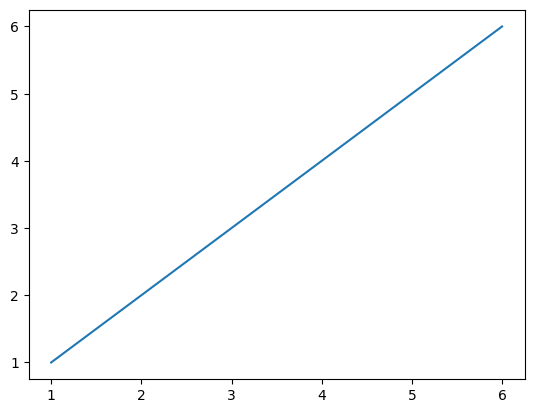

In [172]:
fig, ax = plt.subplots() 

x = [1,2,3,4,5,6]
print(x)
ax.plot(x,x)
#plt.plot(equity_curve[0],equity_curve[1])
plt.show()